In [ ]:
# install dependencies
!pip install -q ultralytics motmetrics filterpy onnxruntime-gpu opencv-python-headless tqdm Pillow gdown


In [ ]:
# CONFIG (run this before Cell 1 and Cell 2)
from pathlib import Path
ROOT = Path("/content/robo_pipeline")
ROOT.mkdir(parents=True, exist_ok=True)

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

PT_MODEL = MODELS_DIR / "best-9.pt"
ONNX_MODEL = MODELS_DIR / "best.onnx"

USE_ONNX = False
IMG_SIZE = 640
STREAM_DETECT = True
VERBOSE = True

RUNS_DIR = ROOT / "runs"
for s in ["input_videos","frames","runs","det_mot","tracks","output_videos","models"]:
    (ROOT / s).mkdir(parents=True, exist_ok=True)


In [ ]:
# Cell 1 — Download model files from Google Drive using gdown
from pathlib import Path
ROOT = Path("/content/robo_pipeline")
MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# === REPLACE these with your Drive file IDs ===
PT_FILE_ID = "1nfOXoF56InISV5hVrKcBZjDFJDUWKntF"
ONNX_FILE_ID = "1J9iHF6z4q8_RoKb1Hrftt6eMKC6Vd1Wz"

pt_target = MODELS_DIR / "best-9.pt"
onnx_target = MODELS_DIR / "best.onnx"

# helper to download if missing
def download_drive_file(file_id: str, out_path: Path):
    if out_path.exists() and out_path.stat().st_size > 0:
        print(f"Already exists: {out_path}")
        return
    print(f"Downloading to {out_path} ... (file id: {file_id})")
    # gdown provides a progress bar in Colab
    cmd = f"gdown --id {file_id} -O {str(out_path)}"
    print("Running:", cmd)
    import subprocess, shlex
    p = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    for line in p.stdout:
        print(line, end='')
    p.wait()
    if p.returncode != 0:
        raise RuntimeError(f"gdown failed with code {p.returncode}")
    print("Download done:", out_path)

# Download if IDs provided
if PT_FILE_ID and PT_FILE_ID != "PUT_YOUR_BEST_PT_FILE_ID_HERE":
    download_drive_file(PT_FILE_ID, pt_target)
else:
    print("PT_FILE_ID not set — please set it to your Drive file id to auto-download.")

if ONNX_FILE_ID and ONNX_FILE_ID != "PUT_YOUR_BEST_ONNX_FILE_ID_HERE":
    download_drive_file(ONNX_FILE_ID, onnx_target)
else:
    print("ONNX_FILE_ID not set — please set it to your Drive file id to auto-download.")

print("Model folder contents:")
!ls -lh /content/robo_pipeline/models || true

Already exists: /content/robo_pipeline/models/best-9.pt
Already exists: /content/robo_pipeline/models/best.onnx
Model folder contents:
total 65M
-rw-r--r-- 1 root root 22M Dec  1 20:20 best-9.pt
-rw-r--r-- 1 root root 43M Dec  1 20:20 best.onnx


In [ ]:
# Cell 2 — Upload video (single) with sanitisation and auto naming
from pathlib import Path
import re, shutil
from google.colab import files

ROOT = Path("/content/robo_pipeline")
INPUT_DIR = ROOT / "input_videos"
INPUT_DIR.mkdir(parents=True, exist_ok=True)

DEFAULT_VIDEO_NAME = "inp-video"
VIDEO_NAME = DEFAULT_VIDEO_NAME
IN_VIDEO = INPUT_DIR / f"{VIDEO_NAME}.mp4"

def sanitize_filename(fname: str, lower: bool = True, spaces_to: str = "-") -> str:
    p = Path(fname)
    stem = p.stem
    ext = p.suffix.lower()
    if lower:
        stem = stem.lower()
    stem = re.sub(r'\s+', spaces_to, stem)
    stem = re.sub(r'[^A-Za-z0-9\-_\.]', '', stem)
    stem = re.sub(r'[-_\.]{2,}', lambda m: m.group(0)[0], stem)
    stem = stem.strip('-_.')
    if not stem:
        stem = "video"
    return stem + ext

print("Choose file(s) to upload. If you cancel, the notebook will use an existing file in /content/robo_pipeline/input_videos/ or the default name.")

uploaded = files.upload()  # user picks file(s)
picked_path = None
if uploaded:
    orig = list(uploaded.keys())[0]
    safe_name = sanitize_filename(orig, lower=True, spaces_to='-')
    dst = INPUT_DIR / safe_name
    try:
        shutil.move(orig, dst)
    except Exception:
        data = uploaded[orig]
        dst.write_bytes(data)
    print(f"Uploaded file saved as: {dst.name}")
    picked_path = dst
    VIDEO_NAME = dst.stem
    IN_VIDEO = dst
else:
    candidates = sorted([p for p in INPUT_DIR.iterdir() if p.is_file() and p.suffix.lower() in ['.mp4','.mov','.mkv','.avi','.webm']])
    if candidates:
        picked_path = candidates[0]
        VIDEO_NAME = picked_path.stem
        IN_VIDEO = picked_path
        print(f"No upload — using first file in input_videos: {picked_path.name}")
    else:
        print("No upload and no existing input video found. To run pipeline, upload a video or place it in /content/robo_pipeline/input_videos/")

# derived paths (kept consistent)
FRAMES_DIR = ROOT / "frames" / VIDEO_NAME
DET_MOT    = ROOT / "det_mot" / f"{VIDEO_NAME}.txt"
TRACKS_OUT = ROOT / "tracks" / f"{VIDEO_NAME}_sort.txt"
OUTPUT_VIDEO = ROOT / "output_videos" / f"{VIDEO_NAME}_annotated.mp4"

print()
print("VIDEO_NAME:", VIDEO_NAME)
print("IN_VIDEO:", IN_VIDEO)
print("FRAMES_DIR:", FRAMES_DIR)
print("DET_MOT:", DET_MOT)
print("TRACKS_OUT:", TRACKS_OUT)
print("OUTPUT_VIDEO:", OUTPUT_VIDEO)


Choose file(s) to upload. If you cancel, the notebook will use an existing file in /content/robo_pipeline/input_videos/ or the default name.


Saving WhatsApp Video 2025-12-09 at 11.06.43.mp4 to WhatsApp Video 2025-12-09 at 11.06.43.mp4
Uploaded file saved as: whatsapp-video-2025-12-09-at-11.06.43.mp4

VIDEO_NAME: whatsapp-video-2025-12-09-at-11.06.43
IN_VIDEO: /content/robo_pipeline/input_videos/whatsapp-video-2025-12-09-at-11.06.43.mp4
FRAMES_DIR: /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43
DET_MOT: /content/robo_pipeline/det_mot/whatsapp-video-2025-12-09-at-11.06.43.txt
TRACKS_OUT: /content/robo_pipeline/tracks/whatsapp-video-2025-12-09-at-11.06.43_sort.txt
OUTPUT_VIDEO: /content/robo_pipeline/output_videos/whatsapp-video-2025-12-09-at-11.06.43_annotated.mp4


In [ ]:
# Choose input video automatically (if IN_VIDEO missing) and set derived paths + safe names + fps fallback
import os, cv2
global VIDEO_NAME, IN_VIDEO, FRAMES_DIR, DET_MOT, TRACKS_OUT, OUTPUT_VIDEO, fps

# pick a video if not present
if not IN_VIDEO.exists():
    vids = sorted((ROOT / "input_videos").glob("*"))
    if not vids:
        raise FileNotFoundError("No input video in /content/robo_pipeline/input_videos — upload one first (run upload cell).")
    match = next((v for v in vids if VIDEO_NAME in v.stem), vids[0])
    safe_stem = re.sub(r'[^A-Za-z0-9_\-]', '_', match.stem)
    VIDEO_NAME = safe_stem
    IN_VIDEO = match

# sanitise derived names (safe)
safe_name = re.sub(r'[^A-Za-z0-9_\-\.]', '_', VIDEO_NAME)
VIDEO_NAME = safe_name
FRAMES_DIR = ROOT / "frames" / VIDEO_NAME
RUNS_DIR   = ROOT / "runs"
DET_MOT    = ROOT / "det_mot" / f"{VIDEO_NAME}.txt"
TRACKS_OUT = ROOT / "tracks" / f"{VIDEO_NAME}_sort.txt"
OUTPUT_VIDEO = ROOT / "output_videos" / f"{VIDEO_NAME}_annotated.mp4"

print("Using input video:", IN_VIDEO)
print("VIDEO_NAME:", VIDEO_NAME)
print("Frames dir:", FRAMES_DIR)
print("Det file:", DET_MOT)
print("Tracks file:", TRACKS_OUT)
print("Output video:", OUTPUT_VIDEO)

# fps fallback: if extract_frames already run earlier, `fps` may exist; otherwise read from file or default
if 'fps' not in globals():
    try:
        cap = cv2.VideoCapture(str(IN_VIDEO))
        fps_val = cap.get(cv2.CAP_PROP_FPS) or 15
        cap.release()
        fps = int(fps_val)
    except:
        fps = 15
else:
    fps = int(fps)
print("Using fps =", fps)


Using input video: /content/robo_pipeline/input_videos/whatsapp-video-2025-12-09-at-11.06.43.mp4
VIDEO_NAME: whatsapp-video-2025-12-09-at-11.06.43
Frames dir: /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43
Det file: /content/robo_pipeline/det_mot/whatsapp-video-2025-12-09-at-11.06.43.txt
Tracks file: /content/robo_pipeline/tracks/whatsapp-video-2025-12-09-at-11.06.43_sort.txt
Output video: /content/robo_pipeline/output_videos/whatsapp-video-2025-12-09-at-11.06.43_annotated.mp4
Using fps = 25


In [ ]:
# Extract frames from video
import cv2
from tqdm import tqdm

def extract_frames(video_path, out_dir, resize=None):
    out_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(str(video_path))
    fps_val = cap.get(cv2.CAP_PROP_FPS) or 25.0
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idx = 1
    pbar = tqdm(total=total or None, desc="Extract frames")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if resize:
            frame = cv2.resize(frame, resize)
        out_path = out_dir / f"{idx:06d}.jpg"
        cv2.imwrite(str(out_path), frame)
        idx += 1
        pbar.update(1)
    cap.release()
    pbar.close()
    print(f"Extracted {idx-1} frames to {out_dir}; fps={fps_val}")
    return fps_val, idx-1

# Run extraction (will skip if frames already exist)
if not any(FRAMES_DIR.glob("*.jpg")):
    fps, n_frames = extract_frames(IN_VIDEO, FRAMES_DIR)
else:
    print("Frames already present, skipping extraction (to re-extract delete frames folder or set FORCE).")


Extract frames: 100%|██████████| 223/223 [00:01<00:00, 158.54it/s]

Extracted 223 frames to /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43; fps=29.973118279569892


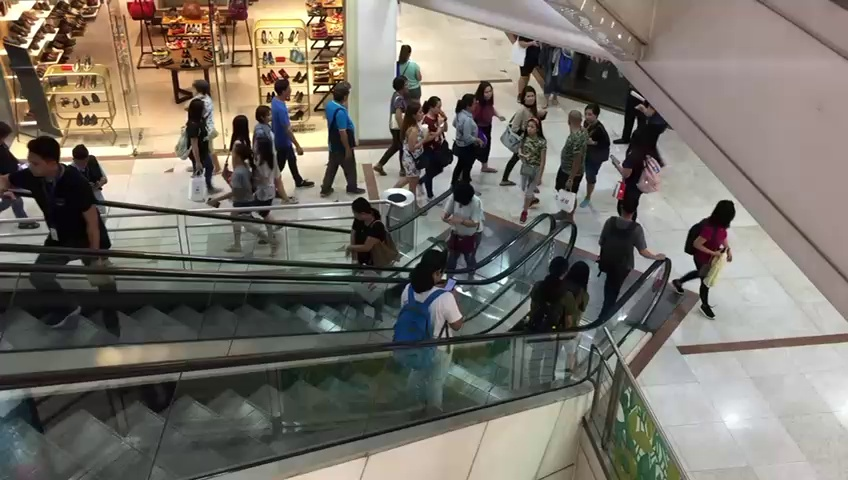

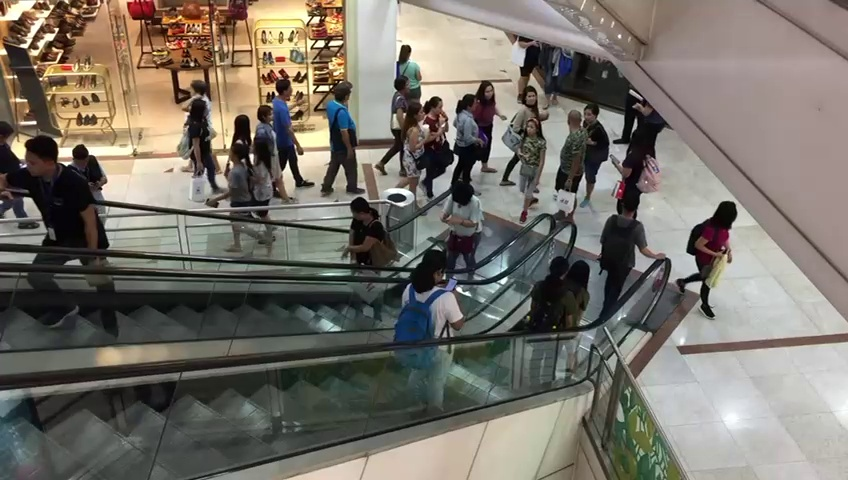

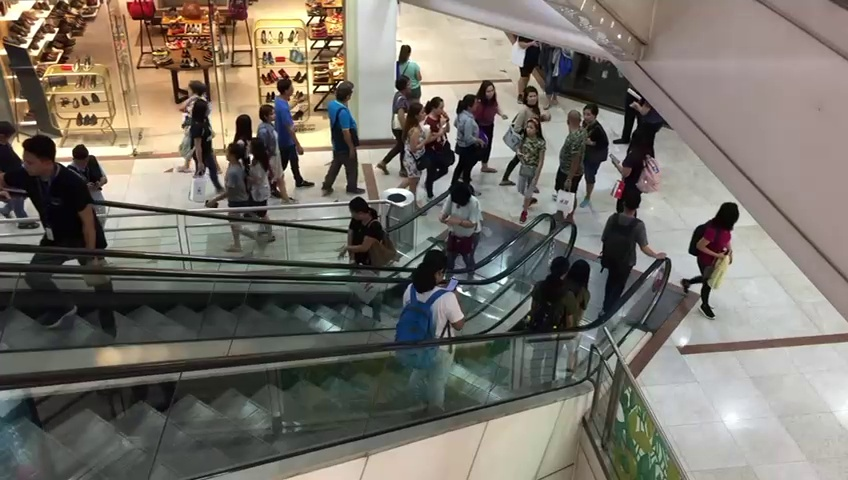

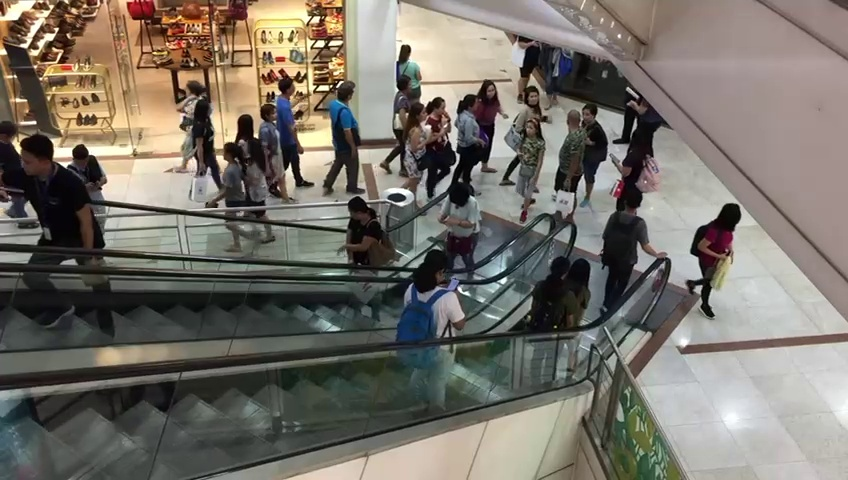

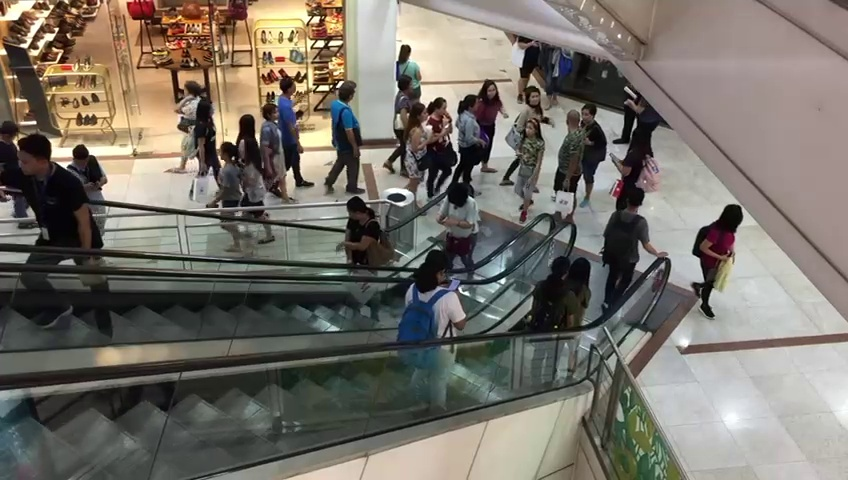

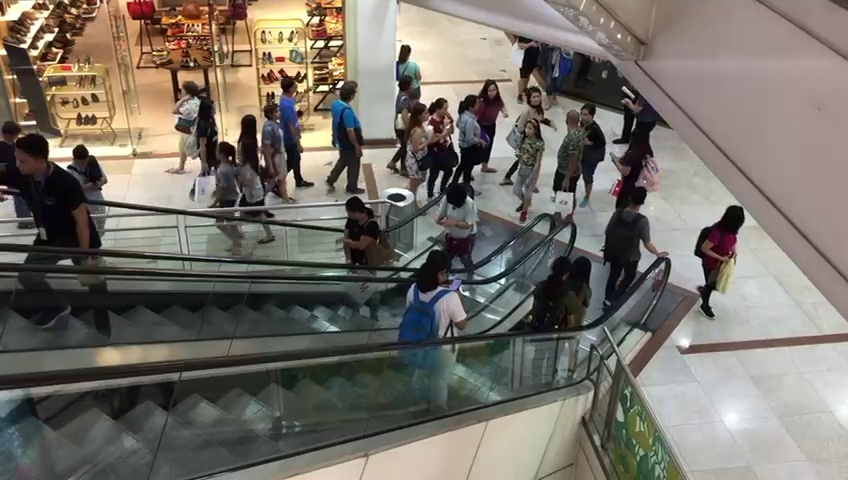

In [ ]:
# Show a few sample frames inline
from IPython.display import Image, display
samples = sorted(FRAMES_DIR.glob("*.jpg"))[:6]
if not samples:
    print("No frames found in", FRAMES_DIR)
else:
    for s in samples:
        display(Image(str(s)))


In [ ]:
# Run YOLO detection over extracted frames (saves labels and annotated images)
from ultralytics import YOLO
import os, time
from pathlib import Path

model_path = str(PT_MODEL) if not USE_ONNX else str(ONNX_MODEL)
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at {model_path}. Upload it to {ROOT/'models'}.")

print("Running detection with model:", model_path)
model = YOLO(model_path)

run_name = f"yt_{VIDEO_NAME}"
labels_dir_expected = RUNS_DIR / run_name / "labels"
print("Detection outputs will be written to:", RUNS_DIR / run_name)

if STREAM_DETECT:
    gen = model.predict(
        source=str(FRAMES_DIR),
        imgsz=IMG_SIZE,
        save=True,
        save_txt=True,
        save_conf=True,
        project=str(RUNS_DIR),
        name=run_name,
        stream=True,
        exist_ok=True
    )
    # iterate generator to force processing and saving
    t0 = time.time()
    processed = 0
    try:
        for res in gen:
            processed += 1
            if processed % 100 == 0 and VERBOSE:
                print(f"Processed {processed} frames...")
    except Exception as e:
        print("Error during streaming detection:", e)
        raise
    finally:
        print(f"Finished detection. Frames iterated: {processed} in {time.time()-t0:.1f}s")
else:
    res = model.predict(
        source=str(FRAMES_DIR),
        imgsz=IMG_SIZE,
        save=True,
        save_txt=True,
        save_conf=True,
        project=str(RUNS_DIR),
        name=run_name,
        stream=False,
        exist_ok=True
    )

# final check
if labels_dir_expected.exists():
    n_txt = len(list(labels_dir_expected.glob("*.txt")))
    nonempty = sum(1 for p in labels_dir_expected.glob("*.txt") if p.stat().st_size>0)
    print("Labels saved to:", labels_dir_expected)
    print(f"Label files: {n_txt}, non-empty: {nonempty}")
else:
    print("Warning: expected labels dir not found at", labels_dir_expected)
    print("List /content/robo_pipeline/runs for debugging:")
    print(list(RUNS_DIR.iterdir()) if RUNS_DIR.exists() else "runs dir missing")


Running detection with model: /content/robo_pipeline/models/best-9.pt
Detection outputs will be written to: /content/robo_pipeline/runs/yt_whatsapp-video-2025-12-09-at-11.06.43

image 1/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000001.jpg: 384x640 36 persons, 22.6ms
image 2/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000002.jpg: 384x640 40 persons, 26.5ms
image 3/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000003.jpg: 384x640 38 persons, 23.3ms
image 4/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000004.jpg: 384x640 37 persons, 27.0ms
image 5/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000005.jpg: 384x640 42 persons, 17.3ms
image 6/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000006.jpg: 384x640 37 persons, 63.9ms
image 7/223 /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000007.jpg: 384x640 34 perso

In [ ]:
# Guard for labels existence and conversion
import glob
from pathlib import Path
from PIL import Image

labels_dir = RUNS_DIR / f"yt_{VIDEO_NAME}" / "labels"
if not labels_dir.exists() or len(list(labels_dir.glob("*.txt"))) == 0:
    raise RuntimeError(f"No YOLO label files found in {labels_dir}. Re-run Cell 5 (detection) or set STREAM_DETECT=False.")

def convert_yolo_to_mot_robust(label_dir, img_dir, out_det_path):
    label_files = sorted(glob.glob(str(Path(label_dir) / "*.txt")))
    img_files = sorted([str(p) for p in Path(img_dir).iterdir() if p.suffix.lower() in ['.jpg','.jpeg','.png','bmp']])
    if not img_files:
        raise FileNotFoundError(f"No images found in {img_dir}")
    img_map = {Path(p).stem: p for p in img_files}
    lines_out = []
    for lf in label_files:
        stem = Path(lf).stem
        img_path = img_map.get(stem)
        frame = None
        if img_path:
            try:
                frame = int(stem)
            except:
                frame = sorted(img_files).index(img_path) + 1
        else:
            matches = [p for p in img_files if Path(p).stem.endswith(stem) or stem.endswith(Path(p).stem)]
            if matches:
                img_path = matches[0]
                try:
                    frame = int(Path(img_path).stem)
                except:
                    frame = sorted(img_files).index(img_path) + 1
            else:
                try:
                    idx = int(stem)
                    sorted_imgs = sorted(img_files)
                    if 1 <= idx <= len(sorted_imgs):
                        img_path = sorted_imgs[idx-1]
                        frame = idx
                except:
                    pass
        if img_path is None or frame is None:
            continue
        try:
            w_img, h_img = Image.open(img_path).size
        except Exception as e:
            print("Failed to open image", img_path, ":", e)
            continue

        with open(lf, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                if len(parts) >= 6:
                    _, xc, yc, w, h, conf = parts[:6]
                    xc, yc, w, h, conf = map(float, (xc, yc, w, h, conf))
                elif len(parts) == 5:
                    _, xc, yc, w, h = parts
                    xc, yc, w, h = map(float, (xc, yc, w, h))
                    conf = 1.0
                else:
                    continue
                abs_w = w * w_img
                abs_h = h * h_img
                left = xc * w_img - abs_w / 2.0
                top  = yc * h_img - abs_h / 2.0
                lines_out.append((frame, f"{frame},{left:.2f},{top:.2f},{abs_w:.2f},{abs_h:.2f},{conf:.4f}"))

    if not lines_out:
        Path(out_det_path).parent.mkdir(parents=True, exist_ok=True)
        Path(out_det_path).write_text("")
        print("Wrote 0 detections to", out_det_path)
        return 0

    lines_sorted = [t[1] for t in sorted(lines_out, key=lambda x: (int(x[0]),))]
    Path(out_det_path).parent.mkdir(parents=True, exist_ok=True)
    with open(out_det_path, 'w') as f:
        for l in lines_sorted:
            f.write(l + "\n")
    print(f"Wrote {len(lines_sorted)} detections to {out_det_path}")
    return len(lines_sorted)

# Run conversion
num = convert_yolo_to_mot_robust(labels_dir, FRAMES_DIR, DET_MOT)
if num == 0:
    raise RuntimeError("No detections produced. Inspect label files and frame naming.")


Wrote 8149 detections to /content/robo_pipeline/det_mot/whatsapp-video-2025-12-09-at-11.06.43.txt


In [ ]:
# Cell 10 (corrected) — SORT tracker (define + optionally run if tracks missing)
from pathlib import Path
import numpy as np, math, os
from scipy.optimize import linear_sum_assignment
from filterpy.kalman import KalmanFilter

# Keep these values in sync with top config if you prefer editing them here
TRACKER_MAX_AGE = TRACKER_MAX_AGE if 'TRACKER_MAX_AGE' in globals() else 30
TRACKER_MIN_HITS = TRACKER_MIN_HITS if 'TRACKER_MIN_HITS' in globals() else 2
TRACKER_IOU = TRACKER_IOU if 'TRACKER_IOU' in globals() else 0.3

def _iou(bbox1, bbox2):
    x1,y1,w1,h1 = bbox1
    x2,y2,w2,h2 = bbox2
    xa = max(x1, x2); ya = max(y1, y2)
    xb = min(x1+w1, x2+w2); yb = min(y1+h1, y2+h2)
    inter_w = max(0.0, xb - xa); inter_h = max(0.0, yb - ya)
    inter = inter_w * inter_h
    union = w1*h1 + w2*h2 - inter
    return inter / (union + 1e-6)

class KalmanBoxTracker:
    count = 0
    def __init__(self, bbox, score):
        # bbox: [l,t,w,h]
        cx = bbox[0] + bbox[2] / 2.0
        cy = bbox[1] + bbox[3] / 2.0
        s = bbox[2] * bbox[3]
        r = bbox[2] / (bbox[3] + 1e-6)
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        dt = 1.0
        self.kf.F = np.eye(7)
        for (a,b) in ((0,4),(1,5),(2,6)):
            self.kf.F[a,b] = dt
        self.kf.H = np.zeros((4,7)); self.kf.H[0,0]=1; self.kf.H[1,1]=1; self.kf.H[2,2]=1; self.kf.H[3,3]=1
        self.kf.P *= 10.0; self.kf.R *= 1.0; self.kf.Q *= 0.01
        self.kf.x[:4,0] = np.array([cx, cy, s, r])
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count + 1
        KalmanBoxTracker.count += 1
        self.hits = 1; self.hit_streak = 1; self.age = 0; self.score = score

    def predict(self):
        self.kf.predict()
        self.age += 1
        if self.time_since_update > 0:
            self.hit_streak = 0
        self.time_since_update += 1
        return self._to_bbox()

    def update(self, bbox, score):
        cx = bbox[0] + bbox[2] / 2.0
        cy = bbox[1] + bbox[3] / 2.0
        s = bbox[2] * bbox[3]
        r = bbox[2] / (bbox[3] + 1e-6)
        z = np.array([cx, cy, s, r])
        self.kf.update(z)
        self.time_since_update = 0
        self.hits += 1; self.hit_streak += 1; self.score = score

    def _to_bbox(self):
        cx, cy, s, r = self.kf.x[0], self.kf.x[1], self.kf.x[2], self.kf.x[3]
        # avoid numpy scalar depreciation issues by explicit float()
        w = float(math.sqrt(abs(float(s) * float(r))))
        h = float(float(s) / (w + 1e-6))
        l = float(cx - w / 2.0); t = float(cy - h / 2.0)
        return [l, t, w, h]

class Sort:
    def __init__(self, max_age=30, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age; self.min_hits = min_hits; self.iou_threshold = iou_threshold
        self.trackers = []

    def update(self, dets):
        predicted = [t.predict() for t in self.trackers]
        N = len(predicted); M = len(dets)
        if N == 0:
            matches, unmatched_dets, unmatched_trks = [], list(range(M)), []
        else:
            iou_matrix = np.zeros((N, M), dtype=np.float32)
            for i,pt in enumerate(predicted):
                for j,det in enumerate(dets):
                    iou_matrix[i,j] = _iou(pt, det[:4])
            row_ind, col_ind = linear_sum_assignment(-iou_matrix)
            matches, unmatched_trks, unmatched_dets = [], [], []
            assigned_trks = set(); assigned_dets = set()
            for r,c in zip(row_ind, col_ind):
                if iou_matrix[r,c] < self.iou_threshold:
                    unmatched_trks.append(r); unmatched_dets.append(c)
                else:
                    matches.append((r,c)); assigned_trks.add(r); assigned_dets.add(c)
            unmatched_trks += [i for i in range(N) if i not in assigned_trks]
            unmatched_dets += [j for j in range(M) if j not in assigned_dets]

        for trk_idx, det_idx in matches:
            self.trackers[trk_idx].update(dets[det_idx][:4], dets[det_idx][4])
        for idx in (unmatched_dets if N>0 else list(range(M))):
            bbox = dets[idx][:4]; score = dets[idx][4]
            self.trackers.append(KalmanBoxTracker(bbox, score))

        retained = []; outputs = []
        for trk in self.trackers:
            if trk.time_since_update < 1 and (trk.hits >= self.min_hits or trk.age <= self.min_hits):
                bbox = trk._to_bbox()
                outputs.append([bbox[0], bbox[1], bbox[2], bbox[3], trk.id, trk.score])
            if trk.time_since_update <= self.max_age:
                retained.append(trk)
        self.trackers = retained
        return outputs

def run_sort_on_det(det_path, out_path, max_age=TRACKER_MAX_AGE, min_hits=TRACKER_MIN_HITS, iou_thresh=TRACKER_IOU):
    """
    Run SORT on det file (lines: frame,left,top,width,height,score)
    Writes out: frame,id,left,top,width,height,score,-1,-1
    """
    det_path = Path(det_path)
    out_path = Path(out_path)
    if not det_path.exists():
        raise FileNotFoundError(f"Detections file not found: {det_path}")
    # reset IDs for deterministic runs
    KalmanBoxTracker.count = 0

    frames = {}
    with det_path.open('r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # accept both comma or space separators (robustness)
            parts = line.replace(' ',',').split(',')
            # after replacement some empty strings may appear -> filter
            parts = [p for p in parts if p!='']
            if len(parts) < 6:
                continue
            try:
                fr = int(float(parts[0]))
                l,t,w,h,score = map(float, parts[1:6])
            except Exception:
                continue
            frames.setdefault(fr, []).append([l,t,w,h,score])

    if not frames:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        out_path.write_text("")
        print("No detections parsed from", det_path)
        return 0

    max_frame = max(frames.keys())
    tracker = Sort(max_age=max_age, min_hits=min_hits, iou_threshold=iou_thresh)
    out_lines = []
    for fr in range(1, max_frame+1):
        dets = frames.get(fr, [])
        tracks = tracker.update(dets)
        for tr in tracks:
            l,t,w,h,tid,score = tr
            out_lines.append(f"{fr},{int(tid)},{l:.2f},{t:.2f},{w:.2f},{h:.2f},{score:.4f},-1,-1\n")
        if (fr % 200) == 0:
            print(f"Processed frames {fr}/{max_frame} ...")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(''.join(out_lines))
    print(f"Wrote {len(out_lines)} track rows to {out_path} (frames: 1..{max_frame})")
    return len(out_lines)

# Run tracker automatically if tracks missing (so visualiser later won't error)
FORCE_TRACK = False  # set True if you want to re-run tracking even if TRACKS_OUT exists
if not Path(TRACKS_OUT).exists() or FORCE_TRACK:
    print("TRACKS_OUT missing or FORCE_TRACK=True — running SORT now...")
    rows = run_sort_on_det(DET_MOT, TRACKS_OUT, max_age=TRACKER_MAX_AGE, min_hits=TRACKER_MIN_HITS, iou_thresh=TRACKER_IOU)
    print("Tracker finished. rows:", rows)
else:
    print("TRACKS_OUT already exists. To re-run, set FORCE_TRACK=True and re-run this cell.")


TRACKS_OUT missing or FORCE_TRACK=True — running SORT now...


/tmp/ipython-input-1305645098.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w = float(math.sqrt(abs(float(s) * float(r))))
/tmp/ipython-input-1305645098.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h = float(float(s) / (w + 1e-6))
/tmp/ipython-input-1305645098.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l = float(cx - w / 2.0); t = float(cy - h / 2.0)


Processed frames 200/223 ...
Wrote 8321 track rows to /content/robo_pipeline/tracks/whatsapp-video-2025-12-09-at-11.06.43_sort.txt (frames: 1..223)
Tracker finished. rows: 8321


In [ ]:
# Cell 11 (corrected) — Visualise tracks and write annotated video (.mp4)
import cv2
from pathlib import Path
import numpy as np, os, hashlib

def id2color(id):
    h = hashlib.sha1(str(id).encode()).digest()
    return (int(h[0])%200+30, int(h[1])%200+30, int(h[2])%200+30)

def visualize_tracks(seq_name, img_folder, tracks_path, out_video_path, downscale=1.0, fps=15, draw_score=True):
    img_folder = Path(img_folder)
    img_files = sorted([str(p) for p in img_folder.glob("*") if p.suffix.lower() in ['.jpg','.png','.jpeg']])
    if not img_files:
        raise FileNotFoundError("No frames found in " + str(img_folder))
    tracks_path = Path(tracks_path)
    if not tracks_path.exists():
        # auto-run tracker (safe) and re-check
        print("Tracks file missing. Running tracker automatically to generate it...")
        run_sort_on_det(str(DET_MOT), str(TRACKS_OUT), max_age=TRACKER_MAX_AGE, min_hits=TRACKER_MIN_HITS, iou_thresh=TRACKER_IOU)
        if not tracks_path.exists():
            raise FileNotFoundError("Tracks file still missing after running tracker: " + str(tracks_path))

    tracks = {}
    with open(tracks_path,'r') as f:
        for line in f:
            parts = [p for p in line.strip().split(',') if p!='']
            if len(parts) < 6: continue
            try:
                fr = int(float(parts[0])); tid = int(float(parts[1]))
                l,t,w,h = map(float, parts[2:6]); score = float(parts[6]) if len(parts)>6 else 1.0
            except Exception:
                continue
            tracks.setdefault(fr, []).append((tid,l,t,w,h,score))

    sample = cv2.imread(img_files[0])
    h0,w0 = sample.shape[:2]
    out_h, out_w = int(h0/downscale), int(w0/downscale)
    writer = cv2.VideoWriter(str(out_video_path), cv2.VideoWriter_fourcc(*'mp4v'), fps, (out_w, out_h))
    total = len(img_files)
    for i, img_path in enumerate(img_files, start=1):
        frame = cv2.imread(img_path)
        if downscale != 1.0:
            frame = cv2.resize(frame, (out_w, out_h))
        objs = tracks.get(i, [])
        for (tid,l,t,w,h,score) in objs:
            x1,y1 = int(l/downscale), int(t/downscale)
            x2,y2 = int((l+w)/downscale), int((t+h)/downscale)
            color = id2color(tid)
            cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
            label = f"ID:{tid}"
            if draw_score: label += f" {score:.2f}"
            cv2.putText(frame, label, (x1, max(10,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)
        writer.write(frame)
        if (i % 200) == 0:
            print(f"Rendered {i}/{total} frames...")
    writer.release()
    print("Wrote video:", out_video_path)

# Call visualiser safely (auto-run tracker if missing)
fps_val = int(fps) if 'fps' in globals() else 15
visualize_tracks(VIDEO_NAME, FRAMES_DIR, TRACKS_OUT, OUTPUT_VIDEO, downscale=1.0, fps=fps_val)
print("Output video:", OUTPUT_VIDEO, "size (MB):", round(os.path.getsize(OUTPUT_VIDEO)/(1024*1024),2) if Path(OUTPUT_VIDEO).exists() else "NA")


Rendered 200/223 frames...
Wrote video: /content/robo_pipeline/output_videos/whatsapp-video-2025-12-09-at-11.06.43_annotated.mp4
Output video: /content/robo_pipeline/output_videos/whatsapp-video-2025-12-09-at-11.06.43_annotated.mp4 size (MB): 11.55


In [ ]:
# One-click runner: extract -> detect -> convert -> track -> visualise
FORCE = False  # set True to force re-run of every stage

# 1. extract frames
if FORCE or not any(FRAMES_DIR.glob("*.jpg")):
    fps, n_frames = extract_frames(IN_VIDEO, FRAMES_DIR)
else:
    print("Frames already exist; skipping extraction.")

# 2. detection (streaming-aware)
labels_path = RUNS_DIR / f"yt_{VIDEO_NAME}" / "labels"
if FORCE or not labels_path.exists():
    model_path = str(PT_MODEL) if not USE_ONNX else str(ONNX_MODEL)
    if not Path(model_path).exists():
        raise FileNotFoundError(f"Model not found: {model_path}")
    model = __import__('ultralytics').YOLO(model_path)

    print("Starting detection (streaming=True). This will iterate frames and save labels to:", RUNS_DIR / f"yt_{VIDEO_NAME}")
    gen = model.predict(source=str(FRAMES_DIR), imgsz=IMG_SIZE, save=True, save_txt=True, save_conf=True,
                        project=str(RUNS_DIR), name=f"yt_{VIDEO_NAME}", stream=True, exist_ok=True)
    proc = 0
    for r in gen:
        proc += 1
        if proc % 200 == 0 and VERBOSE:
            print(f"Processed {proc} frames...")
    print("Detection generator finished; processed:", proc)
else:
    print("Detection outputs exist; skipping detection.")

# 3. convert
labels_dir = RUNS_DIR / f"yt_{VIDEO_NAME}" / "labels"
if not labels_dir.exists() or len(list(labels_dir.glob("*.txt"))) == 0:
    raise RuntimeError(f"No YOLO label files found in {labels_dir}. Re-run detection (Cell 5).")
num = convert_yolo_to_mot_robust(labels_dir, FRAMES_DIR, DET_MOT)
if num == 0:
    raise RuntimeError("Conversion produced 0 detections. Check labels and retry.")

# 4. track
run_sort_on_det(DET_MOT, TRACKS_OUT, max_age=TRACKER_MAX_AGE, min_hits=TRACKER_MIN_HITS, iou_thresh=TRACKER_IOU)

# 5. visualize
fps_val = int(fps) if 'fps' in globals() else 15
visualize_tracks(VIDEO_NAME, FRAMES_DIR, TRACKS_OUT, OUTPUT_VIDEO, downscale=1.0, fps=fps_val)
print("Pipeline done. Annotated video:", OUTPUT_VIDEO)


Frames already exist; skipping extraction.
Detection outputs exist; skipping detection.
Wrote 8149 detections to /content/robo_pipeline/det_mot/whatsapp-video-2025-12-09-at-11.06.43.txt


/tmp/ipython-input-1305645098.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w = float(math.sqrt(abs(float(s) * float(r))))
/tmp/ipython-input-1305645098.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h = float(float(s) / (w + 1e-6))
/tmp/ipython-input-1305645098.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l = float(cx - w / 2.0); t = float(cy - h / 2.0)


Processed frames 200/223 ...
Wrote 8321 track rows to /content/robo_pipeline/tracks/whatsapp-video-2025-12-09-at-11.06.43_sort.txt (frames: 1..223)
Rendered 200/223 frames...
Wrote video: /content/robo_pipeline/output_videos/whatsapp-video-2025-12-09-at-11.06.43_annotated.mp4
Pipeline done. Annotated video: /content/robo_pipeline/output_videos/whatsapp-video-2025-12-09-at-11.06.43_annotated.mp4


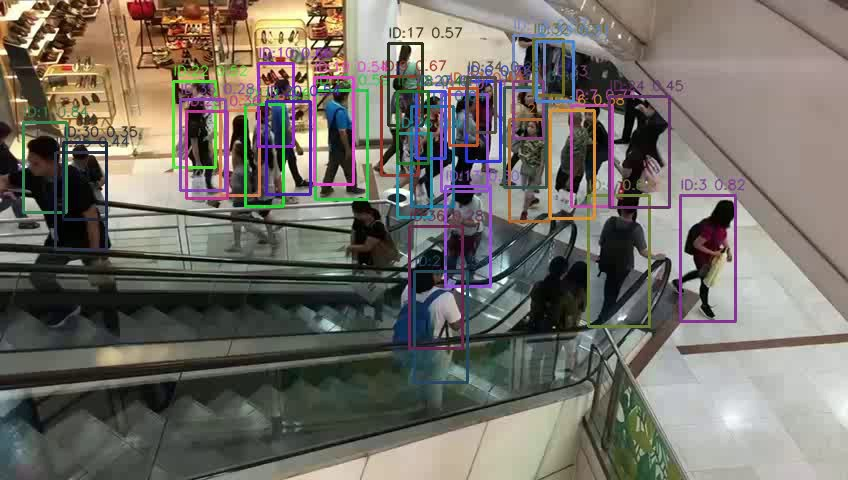

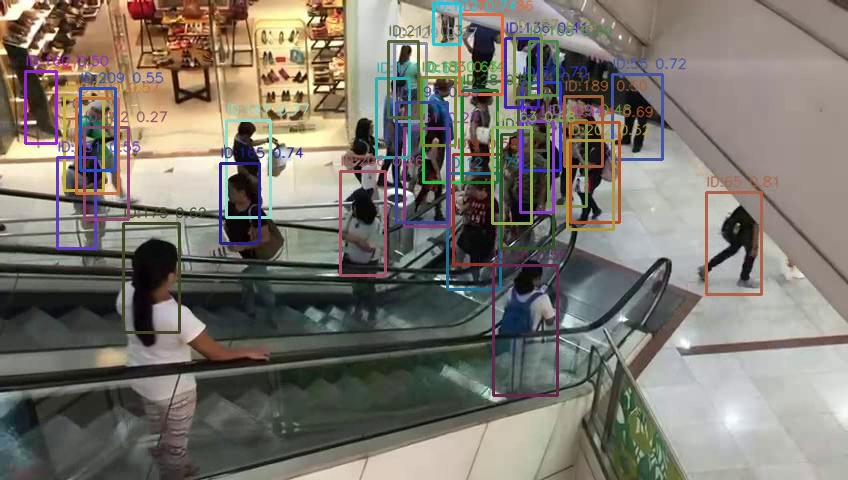

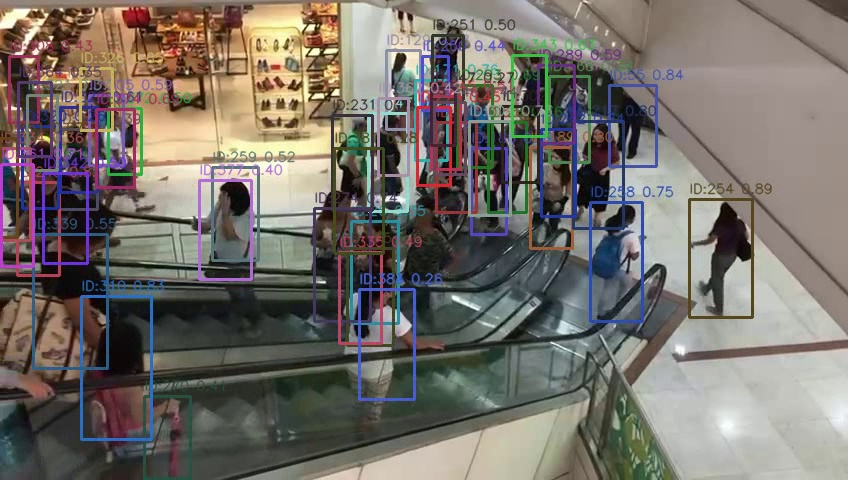

In [ ]:
# Show a few annotated frames inline (first, middle, last) — helpful for live demo preview
from IPython.display import Image, display
annot_frames = sorted(list((ROOT/"output_videos").glob("*.mp4")))
# If video exists, extract a couple of frames (fallback show from frames + overlay from tracks)
preview_paths = []
if OUTPUT_VIDEO.exists():
    # extract a few frames from the annotated video using cv2 (quick & dirty)
    cap = cv2.VideoCapture(str(OUTPUT_VIDEO))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    picks = [1, max(1, total//2), max(1, total-1)]
    for idx in picks:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx-1)
        ret, fr = cap.read()
        if ret:
            tmp = ROOT / f"_preview_{idx:06d}.jpg"
            cv2.imwrite(str(tmp), fr)
            preview_paths.append(tmp)
    cap.release()
if not preview_paths:
    # fallback: use original frames
    frames = sorted(FRAMES_DIR.glob("*.jpg"))
    preview_paths = frames[:3]
for p in preview_paths:
    display(Image(str(p)))


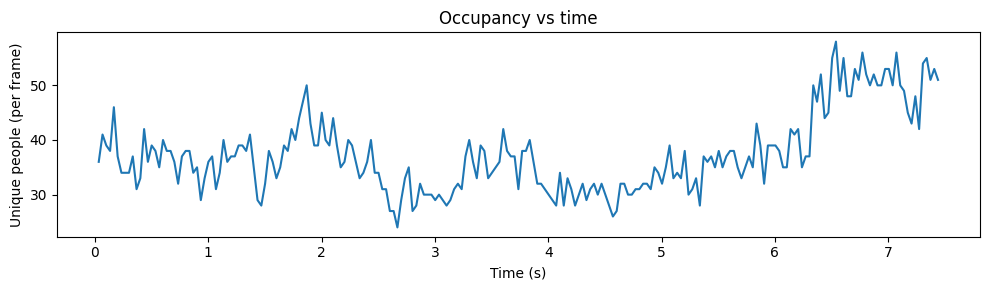

Saved: /content/robo_pipeline/analysis/people_count_per_frame.csv


In [ ]:
# crowd_count.py
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

tracks_path = Path(TRACKS_OUT)  # your tracks file path
df = pd.read_csv(tracks_path, header=None, names=[
    "frame","id","left","top","w","h","score","x","y"
])
counts = df.groupby("frame")["id"].nunique().rename("people_count")
counts.index = counts.index.astype(int)

# save CSV
out_csv = Path("/content/robo_pipeline/analysis/people_count_per_frame.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
counts.to_csv(out_csv, header=True)

# simple plot
plt.figure(figsize=(10,3))
plt.plot(counts.index / fps, counts.values)   # x-axis in seconds
plt.xlabel("Time (s)")
plt.ylabel("Unique people (per frame)")
plt.title("Occupancy vs time")
plt.tight_layout()
plt.show()
print("Saved:", out_csv)


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

ANALYSIS_DIR = Path("/content/robo_pipeline/analysis")
TRACKS_OUT = Path("/content/robo_pipeline/tracks.txt")
DWELL_CSV = ANALYSIS_DIR / "dwell_times.csv"
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

def compute_dwell(tracks_path, fps=30):
    cols = ["frame","id","l","t","w","h","score","a","b"]
    df = pd.read_csv(tracks_path, header=None, names=cols)
    grp = df.groupby("id")["frame"].agg(["min","max","count"]).reset_index()
    grp["dwell_seconds"] = (grp["max"] - grp["min"] + 1) / fps
    return grp.sort_values("dwell_seconds", ascending=False)

if not DWELL_CSV.exists():
    if TRACKS_OUT.exists():
        compute_dwell(TRACKS_OUT).to_csv(DWELL_CSV, index=False)
    else:
        sample = [
            {"id":12,"min":5,"max":605,"count":601,"dwell_seconds":20.03},
            {"id":3,"min":120,"max":360,"count":241,"dwell_seconds":8.03},
            {"id":7,"min":400,"max":540,"count":141,"dwell_seconds":4.70},
            {"id":5,"min":50,"max":250,"count":201,"dwell_seconds":6.70},
            {"id":44,"min":30,"max":330,"count":301,"dwell_seconds":10.03},
            {"id":2,"min":15,"max":75,"count":61,"dwell_seconds":2.00},
            {"id":21,"min":10,"max":30,"count":21,"dwell_seconds":0.70},
        ]
        pd.DataFrame(sample).to_csv(DWELL_CSV, index=False)

df = pd.read_csv(DWELL_CSV)

# Filter only those with at least 1 second dwell time
df = df[df["dwell_seconds"] >= 1]

# Build preview: top 5 longest, 5 random, 5 shortest
top5 = df.nlargest(5, "dwell_seconds")
rand5 = df.sample(min(5, len(df)), random_state=42)
bottom5 = df.nsmallest(5, "dwell_seconds")
preview = pd.concat([top5, rand5, bottom5]).drop_duplicates().reset_index(drop=True)

display(preview)
print("Loaded from:", DWELL_CSV)


id  min  max  count  dwell_seconds
0  12    5  605    601          20.03
1  44   30  330    301          10.03
2   3  120  360    241           8.03
3   5   50  250    201           6.70
4   7  400  540    141           4.70
5   2   15   75     61           2.00

Loaded from: /content/robo_pipeline/analysis/dwell_times.csv


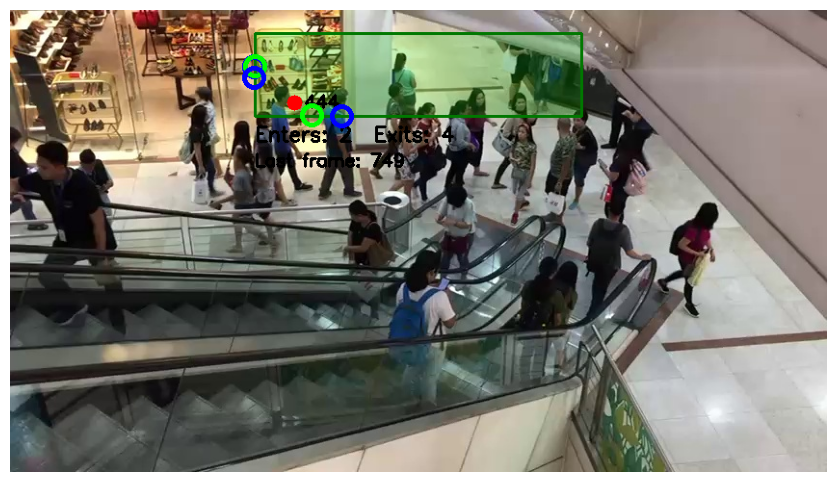

Tracks used: /content/robo_pipeline/tracks/the-city-people-walking-on-the-street-overhead-view-online-video-cutter.com_sort.txt
Preview frame: /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000001.jpg
Zone coords: [(254, 24), (593, 24), (593, 110), (254, 110)]
Saved preview: /content/robo_pipeline/analysis/zone_preview.png
Saved events: /content/robo_pipeline/analysis/zone_events.csv
Total enters: 2 Total exits: 4
IDs inside (last frame): [444]


In [ ]:
import cv2, numpy as np, pandas as pd, glob
from pathlib import Path

ROOT = Path("/content/robo_pipeline")
ANALYSIS = ROOT / "analysis"; ANALYSIS.mkdir(parents=True, exist_ok=True)
OUT_EVENTS = ANALYSIS / "zone_events.csv"
OUT_PREVIEW = ANALYSIS / "zone_preview.png"

# derive candidates from notebook variables if present
try:
    FRAMES_DIR = Path(FRAMES_DIR)
except Exception:
    FRAMES_DIR = ROOT / "frames"
try:
    TRACKS_OUT = Path(TRACKS_OUT)
except Exception:
    TRACKS_OUT = None
if TRACKS_OUT is None or not TRACKS_OUT.exists():
    cand = sorted((ROOT / "tracks").glob("*.txt")) + sorted((ROOT).glob("**/*tracks*.txt"))
    TRACKS_OUT = cand[0] if cand else None

# pick a real sample frame
def find_frame(d):
    if not d.exists(): return None, None
    files = sorted(list(d.glob("**/*.jpg")) + list(d.glob("**/*.png")))
    for p in files:
        im = cv2.imread(str(p))
        if im is not None:
            return im, p
    return None, None

sample_img, src = find_frame(FRAMES_DIR)
if sample_img is None:
    vids = list((ROOT / "input_videos").glob("*"))
    if vids:
        cap = cv2.VideoCapture(str(vids[0])); ok, frame = cap.read(); cap.release()
        if ok: sample_img, src = frame, vids[0]
if sample_img is None:
    H,W = 720,1280
    sample_img = 255*np.ones((H,W,3), dtype=np.uint8); src = "synthetic"
H, W = sample_img.shape[:2]

zone_w = int(W * 0.4); zone_h = int(H * 0.18)
zx1 = (W - zone_w)//2; zy1 = max(0, int(H*0.05)); zx2 = zx1 + zone_w; zy2 = zy1 + zone_h

if TRACKS_OUT is None or not TRACKS_OUT.exists():
    print("Tracks file not found. Checked:", TRACKS_OUT)
    events_df = pd.DataFrame(columns=["id","type","frame"])
else:
    names = ["frame","id","l","t","w","h","score","a","b"]
    tr = pd.read_csv(TRACKS_OUT, header=None, names=names, usecols=range(7))
    tr = tr.dropna(subset=["frame","id"]).copy()
    tr[["frame","id"]] = tr[["frame","id"]].astype(int)
    tr[["l","t","w","h"]] = tr[["l","t","w","h"]].astype(float)
    tr["cx"] = tr["l"] + tr["w"]/2
    tr["cy"] = tr["t"] + tr["h"]/2

    def inside(x,y): return (x>=zx1)&(x<=zx2)&(y>=zy1)&(y<=zy2)

    events = []
    for pid, g in tr.groupby("id"):
        g = g.sort_values("frame")
        ins = inside(g["cx"].values, g["cy"].values).astype(int)
        diff = np.diff(ins, prepend=ins[0])
        enters = np.where(diff==1)[0]
        exits = np.where(diff==-1)[0]
        for i in enters: events.append({"id":int(pid),"type":"enter","frame":int(g["frame"].values[i])})
        for i in exits:  events.append({"id":int(pid),"type":"exit","frame":int(g["frame"].values[i])})
    events_df = pd.DataFrame(events).sort_values(["frame","id"]).reset_index(drop=True)
    events_df.to_csv(OUT_EVENTS, index=False)

# preview image annotate
img = sample_img.copy()
overlay = img.copy()
cv2.rectangle(overlay,(zx1,zy1),(zx2,zy2),(0,200,0),-1); cv2.addWeighted(overlay,0.22,img,0.78,0,img)
cv2.rectangle(img,(zx1,zy1),(zx2,zy2),(0,120,0),2)
total_enters = int((events_df["type"]=="enter").sum()) if not events_df.empty else 0
total_exits = int((events_df["type"]=="exit").sum()) if not events_df.empty else 0
last_frame = int(tr["frame"].max()) if ('tr' in locals() and not tr.empty) else None
cv2.putText(img, f"Enters: {total_enters}  Exits: {total_exits}", (zx1, zy2+26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)
if last_frame is not None:
    cv2.putText(img, f"Last frame: {last_frame}", (zx1, zy2+52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)
    frame_recs = tr[tr["frame"]==last_frame].copy()
    frame_recs["inside"] = inside(frame_recs["cx"], frame_recs["cy"]).astype(int)
    inside_ids = frame_recs[frame_recs["inside"]==1]["id"].astype(int).tolist()
else:
    inside_ids = []

for pid in inside_ids[:200]:
    r = tr[(tr["id"]==pid)&(tr["frame"]==last_frame)]
    if not r.empty:
        x=int(r.iloc[0]["cx"]); y=int(r.iloc[0]["cy"])
        cv2.circle(img,(x,y),8,(0,0,255),-1); cv2.putText(img,str(int(pid)),(x+10,y+5),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2)

if not events_df.empty:
    for _, row in events_df.tail(20).iterrows():
        f=row["frame"]; pid=row["id"]; typ=row["type"]
        rec = tr[(tr["id"]==pid)&(tr["frame"]==f)]
        if not rec.empty:
            x=int(rec.iloc[0]["cx"]); y=int(rec.iloc[0]["cy"])
            color=(0,255,0) if typ=="enter" else (255,0,0)
            cv2.circle(img,(x,y),10,color,3)

cv2.imwrite(str(OUT_PREVIEW), img)
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

print("Tracks used:", TRACKS_OUT)
print("Preview frame:", src)
print("Zone coords:", [(zx1,zy1),(zx2,zy1),(zx2,zy2),(zx1,zy2)])
print("Saved preview:", OUT_PREVIEW)
print("Saved events:", OUT_EVENTS if OUT_EVENTS.exists() else "<no events file>")
print("Total enters:", total_enters, "Total exits:", total_exits)
print("IDs inside (last frame):", inside_ids[:50])


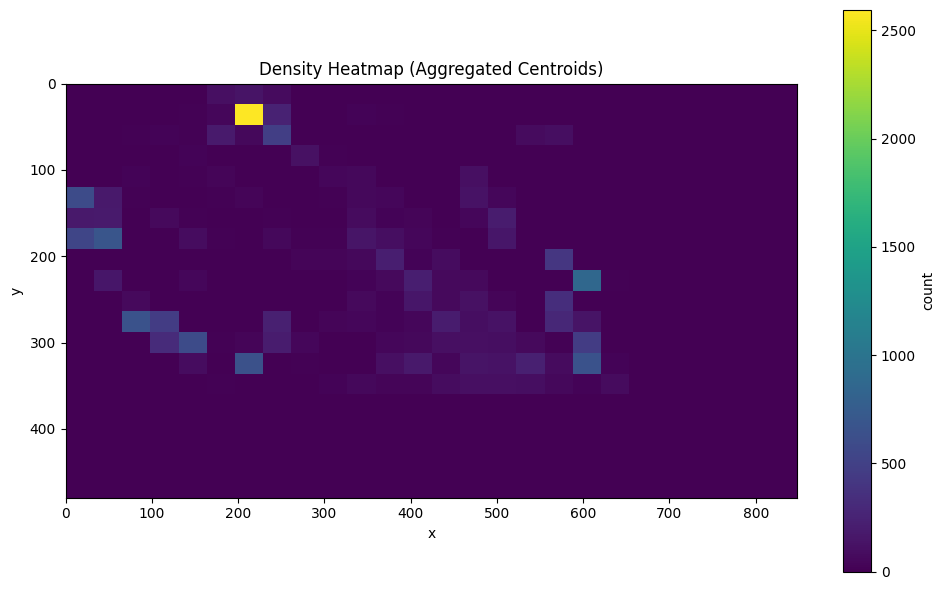

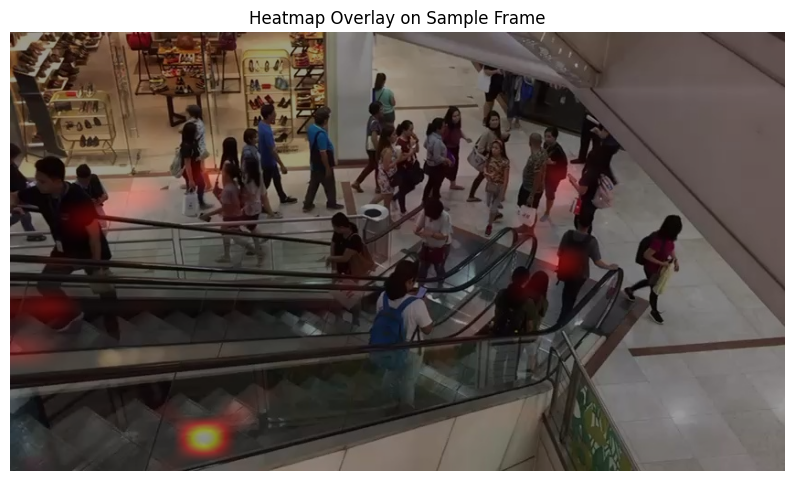

Saved plain heatmap: /content/robo_pipeline/analysis/density_heatmap.png
Saved overlay heatmap: /content/robo_pipeline/analysis/density_heatmap_overlay.png
Sample frame: /content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000001.jpg


In [ ]:
import cv2, numpy as np, pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

ROOT = Path("/content/robo_pipeline")
ANALYSIS = ROOT / "analysis"; ANALYSIS.mkdir(parents=True, exist_ok=True)
OUT_HEAT = ANALYSIS / "density_heatmap.png"
OUT_OVERLAY = ANALYSIS / "density_heatmap_overlay.png"

# Resolve paths
TRACKS_OUT = Path(globals().get("TRACKS_OUT", ROOT / "tracks" / "tracks_sort.txt"))
FRAMES_DIR = Path(globals().get("FRAMES_DIR", ROOT / "frames"))

# Pick sample frame
sample_img = None
sample_frame_path = None
files = sorted(list(FRAMES_DIR.glob("**/*.jpg")) + list(FRAMES_DIR.glob("**/*.png")))
for p in files:
    im = cv2.imread(str(p))
    if im is not None:
        sample_img = im
        sample_frame_path = p
        break

if sample_img is None:
    vids = list((ROOT / "input_videos").glob("*"))
    if vids:
        cap = cv2.VideoCapture(str(vids[0]))
        ok, frame = cap.read()
        cap.release()
        if ok:
            sample_img = frame
            sample_frame_path = vids[0]

if sample_img is None:
    H, W = 720, 1280
    sample_img = 255 * np.ones((H, W, 3), dtype=np.uint8)
else:
    H, W = sample_img.shape[:2]

if not TRACKS_OUT.exists():
    raise FileNotFoundError("Tracks file not found: " + str(TRACKS_OUT))

# Load tracks
cols = ["frame","id","l","t","w","h","score","a","b"]
tr = pd.read_csv(TRACKS_OUT, header=None, names=cols, usecols=range(7))
tr = tr.dropna(subset=["l","t","w","h"]).copy()

# detect pixel vs normalized
numeric = tr[["l","t","w","h"]].astype(float)
maxs = numeric.max().to_dict()
normalized = max(maxs.values()) <= 1.0

if normalized:
    tr["l_px"] = tr["l"] * W
    tr["t_px"] = tr["t"] * H
    tr["w_px"] = tr["w"] * W
    tr["h_px"] = tr["h"] * H
else:
    tr["l_px"] = tr["l"]
    tr["t_px"] = tr["t"]
    tr["w_px"] = tr["w"]
    tr["h_px"] = tr["h"]

tr["cx"] = tr["l_px"] + tr["w_px"]/2
tr["cy"] = tr["t_px"] + tr["h_px"]/2

xs = tr["cx"].clip(0, W-1).values
ys = tr["cy"].clip(0, H-1).values

# Heatmap generation
bx = max(20, W//32)
by = max(20, H//32)
heat, xedges, yedges = np.histogram2d(ys, xs, bins=[by, bx], range=[[0,H],[0,W]])
heat = np.flipud(heat)

# --- DISPLAY PLAIN HEATMAP ---
plt.figure(figsize=(10,6))
plt.imshow(heat, interpolation="nearest", extent=[0,W,0,H])
plt.gca().invert_yaxis()
plt.xlabel("x"); plt.ylabel("y")
plt.title("Density Heatmap (Aggregated Centroids)")
plt.colorbar(label="count")
plt.tight_layout()
plt.show()

# Save plain heatmap
plt.imsave(OUT_HEAT, heat, cmap='hot')

# Heatmap overlay
heat_norm = (heat - heat.min()) / (np.ptp(heat) + 1e-9)
heat_resized = cv2.resize(heat_norm, (W, H), interpolation=cv2.INTER_CUBIC)
heat_col = plt.cm.hot(heat_resized)[:, :, :3]
heat_col = (heat_col * 255).astype(np.uint8)
overlay = cv2.addWeighted(sample_img, 0.6, cv2.cvtColor(heat_col, cv2.COLOR_RGB2BGR), 0.4, 0)

# --- DISPLAY OVERLAY ---
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Heatmap Overlay on Sample Frame")
plt.show()

# save overlay
cv2.imwrite(str(OUT_OVERLAY), overlay)

print("Saved plain heatmap:", OUT_HEAT)
print("Saved overlay heatmap:", OUT_OVERLAY)
print("Sample frame:", sample_frame_path if sample_frame_path else "synthetic")


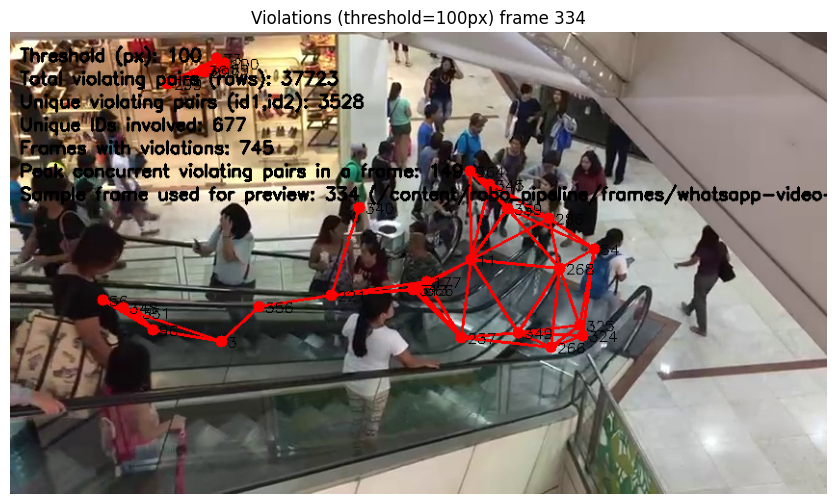

Saved CSV: /content/robo_pipeline/analysis/dist_violations.csv
Saved image: /content/robo_pipeline/analysis/dist_violations_sample_fixed.png
Saved summary: /content/robo_pipeline/analysis/dist_violations_summary.txt
Threshold (px): 100
Total violating pairs (rows): 37723
Unique violating pairs (id1,id2): 3528
Unique IDs involved: 677
Frames with violations: 745
Peak concurrent violating pairs in a frame: 149
Sample frame used for preview: 334 (/content/robo_pipeline/frames/whatsapp-video-2025-12-09-at-11.06.43/000223.jpg)


In [ ]:
import cv2, numpy as np, pandas as pd
from pathlib import Path

ROOT = Path("/content/robo_pipeline")
ANALYSIS = ROOT / "analysis"; ANALYSIS.mkdir(parents=True, exist_ok=True)
TRACKS_OUT = Path(globals().get("TRACKS_OUT", ROOT / "tracks" / f"{globals().get('VIDEO_NAME','video')}_sort.txt"))
FRAMES_DIR = Path(globals().get("FRAMES_DIR", ROOT / "frames" / globals().get("VIDEO_NAME","video")))
OUT_CSV = ANALYSIS / "dist_violations.csv"
OUT_IMG = ANALYSIS / "dist_violations_sample_fixed.png"
OUT_SUM = ANALYSIS / "dist_violations_summary.txt"
THRESH_PIX = 100

if not TRACKS_OUT.exists():
    raise FileNotFoundError("Tracks not found: " + str(TRACKS_OUT))

cols = ["frame","id","l","t","w","h","score","a","b"]
tr = pd.read_csv(TRACKS_OUT, header=None, names=cols, usecols=range(7)).dropna(subset=["l","t","w","h"]).copy()
tr[["frame","id"]] = tr[["frame","id"]].astype(int)
tr[["l","t","w","h"]] = tr[["l","t","w","h"]].astype(float)

maxs = tr[["l","t","w","h"]].max().to_dict()
normalized = max(maxs.values()) <= 1.0

def to_px(df, W, H):
    if normalized:
        df["l_px"] = df["l"] * W; df["t_px"] = df["t"] * H; df["w_px"] = df["w"] * W; df["h_px"] = df["h"] * H
    else:
        df["l_px"] = df["l"]; df["t_px"] = df["t"]; df["w_px"] = df["w"]; df["h_px"] = df["h"]
    df["cx"] = df["l_px"] + df["w_px"] / 2; df["cy"] = df["t_px"] + df["h_px"] / 2
    return df

def load_any_frame():
    files = sorted(list(FRAMES_DIR.glob("**/*.jpg")) + list(FRAMES_DIR.glob("**/*.png")))
    if not files:
        return None, None
    p = files[0]; im = cv2.imread(str(p))
    return im, p

sample_img_any, _ = load_any_frame()
if sample_img_any is None:
    H, W = 720, 1280
else:
    H, W = sample_img_any.shape[:2]

tr = to_px(tr, W, H)

rows = []
for fr, g in tr.groupby("frame"):
    pts = g[["id","cx","cy"]].values
    n = len(pts)
    for i in range(n):
        for j in range(i+1, n):
            id1, x1, y1 = pts[i]; id2, x2, y2 = pts[j]
            d = np.hypot(x1 - x2, y1 - y2)
            if d < THRESH_PIX:
                rows.append({"frame": int(fr), "id1": int(id1), "id2": int(id2), "dist": float(d)})

dfv = pd.DataFrame(rows)
dfv.to_csv(OUT_CSV, index=False)

total_pairs = int(len(dfv))
unique_pairs = int(dfv[["id1","id2"]].drop_duplicates().shape[0]) if not dfv.empty else 0
unique_ids = int(pd.unique(dfv[["id1","id2"]].values.ravel()).size) if not dfv.empty else 0
frames_with = int(dfv["frame"].nunique()) if not dfv.empty else 0
peak_frame_count = int(dfv.groupby("frame").size().max()) if not dfv.empty else 0

if not dfv.empty:
    sample_frame_num = int(dfv["frame"].median())
else:
    sample_frame_num = int(tr["frame"].median())

candidates = [f"{sample_frame_num:06d}.jpg", f"{sample_frame_num:06d}.png",
              f"{sample_frame_num:05d}.jpg", f"{sample_frame_num}.jpg", f"{sample_frame_num}.png"]
sample_img = None; sample_path = None
for name in candidates:
    p = FRAMES_DIR / name
    if p.exists():
        im = cv2.imread(str(p))
        if im is not None:
            sample_img, sample_path = im, p
            break

if sample_img is None:
    files = sorted(list(FRAMES_DIR.glob("**/*.jpg")) + list(FRAMES_DIR.glob("**/*.png")))
    if files:
        for p in files:
            if p.stem.endswith(str(sample_frame_num)):
                im = cv2.imread(str(p))
                if im is not None:
                    sample_img, sample_path = im, p
                    break
    if sample_img is None and files:
        sample_path = files[min(len(files)-1, max(0, sample_frame_num-1))]
        sample_img = cv2.imread(str(sample_path))

if sample_img is None:
    sample_img = 255 * np.ones((720,1280,3), dtype=np.uint8); sample_path = "synthetic"
H, W = sample_img.shape[:2]

if normalized:
    tr = to_px(tr, W, H)

img = sample_img.copy()
if sample_frame_num in tr["frame"].values and not dfv.empty:
    pairs = dfv[dfv["frame"] == sample_frame_num]
    for _, r in pairs.iterrows():
        a = tr[(tr["frame"] == r["frame"]) & (tr["id"] == r["id1"])].iloc[0]
        b = tr[(tr["frame"] == r["frame"]) & (tr["id"] == r["id2"])].iloc[0]
        x1, y1 = int(a["cx"]), int(a["cy"]); x2, y2 = int(b["cx"]), int(b["cy"])
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.circle(img, (x1, y1), 6, (0, 0, 255), -1); cv2.circle(img, (x2, y2), 6, (0, 0, 255), -1)
        cv2.putText(img, str(int(a["id"])), (x1+6, y1+6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
        cv2.putText(img, str(int(b["id"])), (x2+6, y2+6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

summary_lines = [
    f"Threshold (px): {THRESH_PIX}",
    f"Total violating pairs (rows): {total_pairs}",
    f"Unique violating pairs (id1,id2): {unique_pairs}",
    f"Unique IDs involved: {unique_ids}",
    f"Frames with violations: {frames_with}",
    f"Peak concurrent violating pairs in a frame: {peak_frame_count}",
    f"Sample frame used for preview: {sample_frame_num} ({sample_path})"
]
with open(OUT_SUM, "w") as f:
    f.write("\n".join(summary_lines))

txt_y = 30
for line in summary_lines:
    cv2.putText(img, line, (10, txt_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)
    txt_y += 24

cv2.imwrite(str(OUT_IMG), img)
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.title(f"Violations (threshold={THRESH_PIX}px) frame {sample_frame_num}"); plt.show()

print("Saved CSV:", OUT_CSV)
print("Saved image:", OUT_IMG)
print("Saved summary:", OUT_SUM)
print("\n".join(summary_lines))


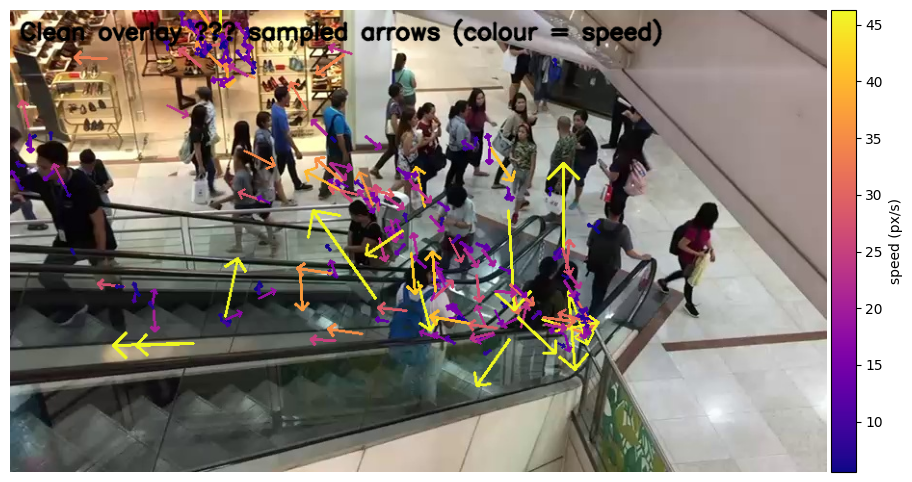

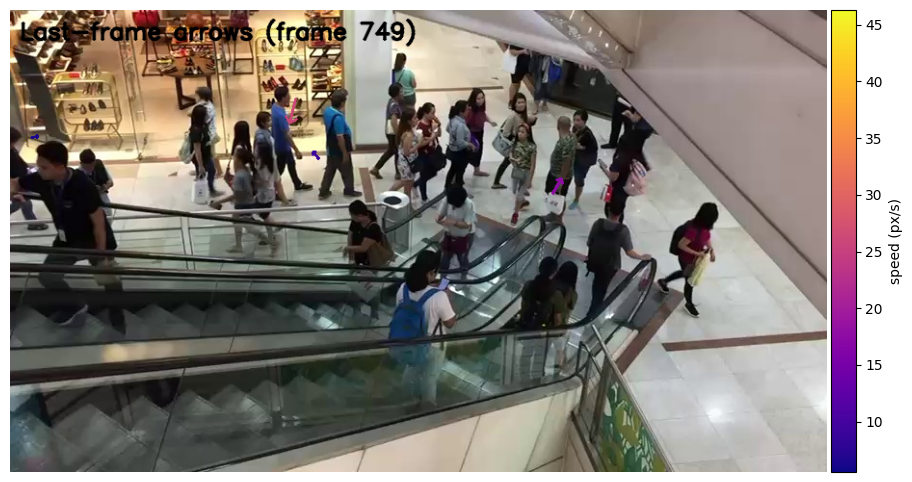

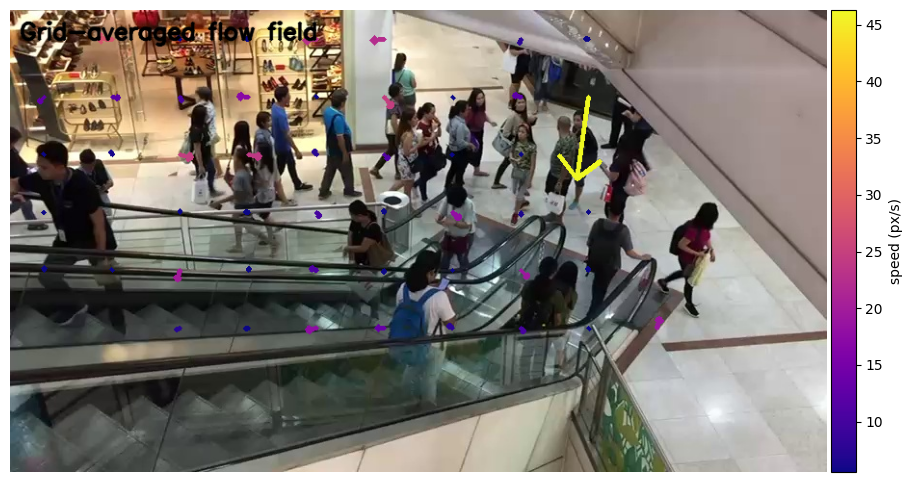

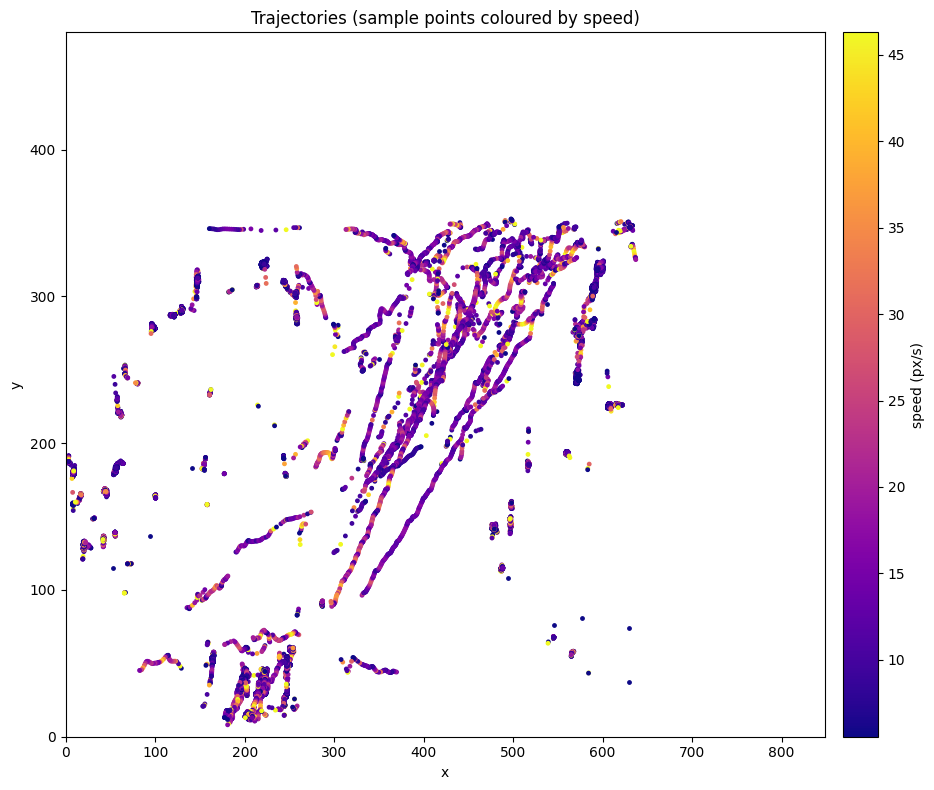

Saved: /content/robo_pipeline/analysis/flow_clean_overlay_labeled.png /content/robo_pipeline/analysis/flow_last_frame_labeled.png /content/robo_pipeline/analysis/flow_grid_labeled.png /content/robo_pipeline/analysis/flow_trajectories_labeled.png


In [ ]:
import cv2, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

ROOT = Path("/content/robo_pipeline")
ANALYSIS = ROOT / "analysis"; ANALYSIS.mkdir(parents=True, exist_ok=True)
TRACKS_OUT = Path(globals().get("TRACKS_OUT", ROOT / "tracks" / f"{globals().get('VIDEO_NAME','video')}_sort.txt"))
FRAMES_DIR = Path(globals().get("FRAMES_DIR", ROOT / "frames" / globals().get("VIDEO_NAME","video")))
OUT_CLEAN = ANALYSIS / "flow_clean_overlay_labeled.png"
OUT_LAST = ANALYSIS / "flow_last_frame_labeled.png"
OUT_GRID = ANALYSIS / "flow_grid_labeled.png"
OUT_TRAJ = ANALYSIS / "flow_trajectories_labeled.png"

fps = int(globals().get("fps", 15))
ROLL_WINDOW = 3
DT_FRAMES = 2
MIN_SPEED_PX_S = 5
SAMPLE_N = 250
GRID_SIZE = (12, 8)

cols = ["frame","id","l","t","w","h","score","a","b"]
tr = pd.read_csv(TRACKS_OUT, header=None, names=cols, usecols=range(7)).dropna(subset=["l","t","w","h"]).copy()
tr[["frame","id"]] = tr[["frame","id"]].astype(int)
tr[["l","t","w","h"]] = tr[["l","t","w","h"]].astype(float)

sample_img = None
files = sorted(list(FRAMES_DIR.glob("**/*.jpg")) + list(FRAMES_DIR.glob("**/*.png")))
for p in files:
    im = cv2.imread(str(p))
    if im is not None:
        sample_img, sample_frame_path = im, p
        break
if sample_img is None:
    vids = list((ROOT / "input_videos").glob("*"))
    if vids:
        cap = cv2.VideoCapture(str(vids[0])); ok, frame = cap.read(); cap.release()
        if ok: sample_img, sample_frame_path = frame, vids[0]
if sample_img is None:
    H, W = 720, 1280
    sample_img = 255 * np.ones((H, W, 3), dtype=np.uint8)
else:
    H, W = sample_img.shape[:2]

maxs = tr[["l","t","w","h"]].max().to_dict()
normalized = max(maxs.values()) <= 1.0
if normalized:
    tr["l_px"] = tr["l"] * W; tr["t_px"] = tr["t"] * H; tr["w_px"] = tr["w"] * W; tr["h_px"] = tr["h"] * H
else:
    tr["l_px"] = tr["l"]; tr["t_px"] = tr["t"]; tr["w_px"] = tr["w"]; tr["h_px"] = tr["h"]
tr["cx"] = tr["l_px"] + tr["w_px"] / 2
tr["cy"] = tr["t_px"] + tr["h_px"] / 2

all_vecs = []
for pid, g in tr.groupby("id"):
    g = g.sort_values("frame").reset_index(drop=True)
    if len(g) < 2: continue
    if ROLL_WINDOW>1 and len(g) >= ROLL_WINDOW:
        g["cx_s"] = g["cx"].rolling(ROLL_WINDOW, min_periods=1, center=True).mean()
        g["cy_s"] = g["cy"].rolling(ROLL_WINDOW, min_periods=1, center=True).mean()
    else:
        g["cx_s"] = g["cx"]; g["cy_s"] = g["cy"]
    g["frame_idx"] = g["frame"].astype(int)
    for i in range(len(g)-DT_FRAMES):
        f0 = int(g.loc[i,"frame_idx"]); f1 = int(g.loc[i+DT_FRAMES,"frame_idx"])
        if f1 <= f0: continue
        dt_s = (f1 - f0) / fps
        dx = g.loc[i+DT_FRAMES,"cx_s"] - g.loc[i,"cx_s"]
        dy = g.loc[i+DT_FRAMES,"cy_s"] - g.loc[i,"cy_s"]
        vx = dx / dt_s; vy = dy / dt_s
        speed = (vx**2 + vy**2)**0.5
        all_vecs.append({"id":int(pid),"frame":f1,"x":float(g.loc[i+DT_FRAMES,"cx_s"]),
                         "y":float(g.loc[i+DT_FRAMES,"cy_s"]),"vx":float(vx),"vy":float(vy),"speed_px_s":float(speed)})
vecs_df = pd.DataFrame(all_vecs)
if vecs_df.empty:
    raise RuntimeError("Not enough track history to compute flow vectors.")
vecs_df = vecs_df[vecs_df["speed_px_s"] >= MIN_SPEED_PX_S].reset_index(drop=True)
vecs_df.to_csv(ANALYSIS/"flow_vectors_final.csv", index=False)

vmin = float(np.percentile(vecs_df["speed_px_s"], 5))
vmax = float(np.percentile(vecs_df["speed_px_s"], 95))
if vmax <= vmin: vmax = vmin + 1.0
cmap = plt.get_cmap("plasma")

sample = vecs_df.sample(min(SAMPLE_N, len(vecs_df)), random_state=2)
median_speed = np.median(sample["speed_px_s"].values) if len(sample)>0 else 1.0
scale = max(1.0, median_speed / 18.0)

overlay = sample_img.copy()
for _, r in sample.iterrows():
    x0,y0 = int(round(r["x"])), int(round(r["y"]))
    dx = int(round(r["vx"] / scale)); dy = int(round(r["vy"] / scale))
    end = (x0+dx, y0+dy)
    norm = float((r["speed_px_s"] - vmin) / (vmax - vmin + 1e-9))
    col = tuple(int(255*c) for c in cmap(max(0.0,min(1.0,norm)))[:3])[::-1]
    cv2.arrowedLine(overlay, (x0,y0), end, col, 2, tipLength=0.25)
cv2.putText(overlay, "Clean overlay — sampled arrows (colour = speed)", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2, cv2.LINE_AA)
fig, ax = plt.subplots(figsize=(12,6)); ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); ax.axis("off")
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)); sm.set_array(vecs_df["speed_px_s"].values)
plt.colorbar(sm, cax=cax).set_label("speed (px/s)")
plt.show(); cv2.imwrite(str(OUT_CLEAN), overlay)

last_frame = int(tr["frame"].max())
last_vecs = vecs_df[vecs_df["frame"]==last_frame]
if last_vecs.empty:
    closest_f = int(vecs_df["frame"].median()); last_vecs = vecs_df[vecs_df["frame"]==closest_f]
overlay2 = sample_img.copy()
for _, r in last_vecs.iterrows():
    x0,y0 = int(round(r["x"])), int(round(r["y"]))
    dx = int(round(r["vx"] / max(1.0, median_speed/18.0))); dy = int(round(r["vy"] / max(1.0, median_speed/18.0)))
    end = (x0+dx, y0+dy)
    norm = float((r["speed_px_s"] - vmin) / (vmax - vmin + 1e-9))
    col = tuple(int(255*c) for c in cmap(max(0.0,min(1.0,norm)))[:3])[::-1]
    cv2.arrowedLine(overlay2, (x0,y0), end, col, 2, tipLength=0.3)
cv2.putText(overlay2, f"Last-frame arrows (frame {last_frame})", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2, cv2.LINE_AA)
fig, ax = plt.subplots(figsize=(12,6)); ax.imshow(cv2.cvtColor(overlay2, cv2.COLOR_BGR2RGB)); ax.axis("off")
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)); sm.set_array(vecs_df["speed_px_s"].values)
plt.colorbar(sm, cax=cax).set_label("speed (px/s)")
plt.show(); cv2.imwrite(str(OUT_LAST), overlay2)

cols_g, rows_g = GRID_SIZE
cell_w = float(W) / cols_g; cell_h = float(H) / rows_g
grid_u = np.zeros((rows_g, cols_g)); grid_v = np.zeros((rows_g, cols_g)); grid_count = np.zeros((rows_g, cols_g))
for _, r in vecs_df.iterrows():
    cx, cy = r["x"], r["y"]
    col_idx = min(cols_g-1, int(cx // cell_w))
    row_idx = min(rows_g-1, int(cy // cell_h))
    grid_u[row_idx, col_idx] += r["vx"]
    grid_v[row_idx, col_idx] += r["vy"]
    grid_count[row_idx, col_idx] += 1
mask = grid_count>0
grid_u[mask] /= grid_count[mask]; grid_v[mask] /= grid_count[mask]
X_coords = (np.arange(cols_g) + 0.5) * cell_w
Y_coords = (np.arange(rows_g) + 0.5) * cell_h
XX, YY = np.meshgrid(X_coords, Y_coords)
img_grid = sample_img.copy()
speeds_grid = np.hypot(grid_u, grid_v)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
for i in range(rows_g):
    for j in range(cols_g):
        if grid_count[i,j] > 0:
            x = int(XX[i,j]); y = int(YY[i,j])
            dx = grid_u[i,j] / max(1.0, median_speed/8.0)
            dy = grid_v[i,j] / max(1.0, median_speed/8.0)
            col = cmap(norm(speeds_grid[i,j]))[:3]; colb = tuple(int(255*c) for c in col)[::-1]
            cv2.arrowedLine(img_grid, (x,y), (int(x+dx), int(y+dy)), colb, 3, tipLength=0.35)
cv2.putText(img_grid, "Grid-averaged flow field", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2, cv2.LINE_AA)
fig, ax = plt.subplots(figsize=(12,6)); ax.imshow(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB)); ax.axis("off")
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array(speeds_grid.flatten())
plt.colorbar(sm, cax=cax).set_label("speed (px/s)")
plt.show(); cv2.imwrite(str(OUT_GRID), img_grid)

fig, ax = plt.subplots(figsize=(10,8)); ax.set_xlim(0, W); ax.set_ylim(H, 0)
norm2 = plt.Normalize(vmin=vmin, vmax=vmax)
for pid, g in tr.groupby("id"):
    g = g.sort_values("frame").reset_index(drop=True)
    if len(g) < DT_FRAMES+1: continue
    if ROLL_WINDOW>1 and len(g) >= ROLL_WINDOW:
        cx_s = g["cx"].rolling(ROLL_WINDOW, min_periods=1, center=True).mean()
        cy_s = g["cy"].rolling(ROLL_WINDOW, min_periods=1, center=True).mean()
    else:
        cx_s = g["cx"]; cy_s = g["cy"]
    xs = []; ys = []; speeds_local = []
    for i in range(len(g)-DT_FRAMES):
        dx = cx_s.iloc[i+DT_FRAMES] - cx_s.iloc[i]
        dy = cy_s.iloc[i+DT_FRAMES] - cy_s.iloc[i]
        dt_s = (g.loc[i+DT_FRAMES,"frame"] - g.loc[i,"frame"]) / fps
        if dt_s <= 0: continue
        sp = np.hypot(dx/dt_s, dy/dt_s)
        xs.append(cx_s.iloc[i+DT_FRAMES]); ys.append(cy_s.iloc[i+DT_FRAMES]); speeds_local.append(sp)
    if not xs: continue
    ax.scatter(xs, ys, c=speeds_local, cmap=cmap, s=6)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm2); sm2.set_array(vecs_df["speed_px_s"].values)
cbar = fig.colorbar(sm2, ax=ax, pad=0.02); cbar.set_label("speed (px/s)")
ax.set_title("Trajectories (sample points coloured by speed)")
ax.set_xlabel("x"); ax.set_ylabel("y")
plt.gca().invert_yaxis(); plt.tight_layout(); plt.savefig(OUT_TRAJ, dpi=150); plt.show()

print("Saved:", OUT_CLEAN, OUT_LAST, OUT_GRID, OUT_TRAJ)
